In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
import seaborn as sns
import dynamic_stock_model as dsm

In [2]:
# Loading data
path = os.getcwd()
data = pd.read_csv(path+"/old_model/dummy_data_battery.csv", header=0 , sep=',')

In [3]:

# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)

# We store the time and inflows values in two lists
time = data['Time'].tolist()
stock_cars = data['Population'].tolist() # FIXME: Is he stock just labeled wrongly as population or is it intended this way?


## Case 1
Cars have a lifetime that includes all types of failures, battery EoL being one of them. No battery replacement. 1 car = one battery, Outflow battery = outflow car 

Since this case includes all possible failures, the choice of lifetime should not be limted to the technical lifetime of the vehicle itself but should also consider how this might be affected by failures in the battery and vehicle crashes. Therefore, the probability that a failure occurs is greater than the techical lifetime of the vehicle itself and leads to a shorter choice of lifetime. 

This is a simpler and less explicit method for accounting for failures of both products with a single lifetime. 

In [4]:
stock_change_1 = [0] + np.diff(stock_cars).tolist()
outflows_cars_1 = [0]
outflows_batteries_1 = [0]
inflows_cars_1 = [0]
inflows_AM_battery_1 = [0]
stock_batteries_1 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 13
st_dev_car = 4

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_1 = 0
    new_outflow_battery_1 = 0
    for cohort in range(i):
        new_outflow_1 += inflows_cars_1[cohort] * pdf_car[i-cohort]
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
        new_outflow_battery_1 = new_outflow_1
    outflows_cars_1.append(new_outflow_1)    
    inflows_cars_1.append(stock_change_1[i] + outflows_cars_1[i])
    outflows_batteries_1.append(new_outflow_battery_1) 
    # additional batteries needed for replacements
    inflows_AM_battery_1.append(new_outflow_battery_1 - new_outflow_1)
    stock_batteries_1.append(stock_batteries_1[-1] + inflows_cars_1[-1] - new_outflow_1)


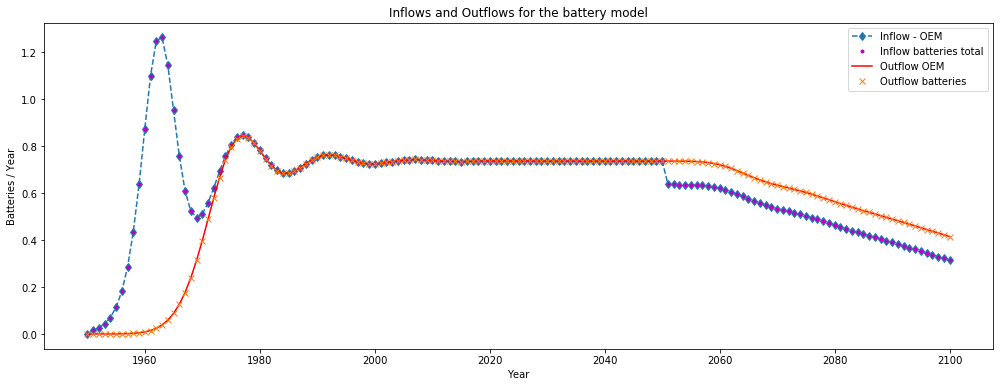

In [5]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_1, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_1, inflows_cars_1)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_1,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_1,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 2
Cars have a lifetime that includes all types of failures, battery EoL being one of them. Still, it is assumed that some batteries will be replaced at a given rate. More than one battery in the lifetime of the car. Outflow battery >= outflow car

In this case the failure of batteries is accounted for by a replacement rate and therefore the lifetime of the vehicle can be assumed to not be affected to the same extent as in case 1. Limitations to this approach might be that the outflows and battery inflows are estimated at different times as the case where a separate lifetime would be calculated for the batteries. It is more suitable if the stock is approximately constant. 

In [6]:
stock_change_2 = [0] + np.diff(stock_cars).tolist()
outflows_cars_2 = [0]
outflows_batteries_2 = [0]
inflows_cars_2 = [0]
inflows_AM_battery_2 = [0]
stock_batteries_2 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 16
st_dev_car = 4

# Definition of replacement rate. Example for the case where 50% of the batteries are replaced
r = 0.5

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_2 = 0
    new_outflow_battery_2 = 0
    for cohort in range(i):
        new_outflow_2 += inflows_cars_2[cohort] * pdf_car[i-cohort]
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
        new_outflow_battery_2 = new_outflow_2 * (1+r)
    outflows_cars_2.append(new_outflow_2)    
    inflows_cars_2.append(stock_change_2[i] + outflows_cars_2[i])
    outflows_batteries_2.append(new_outflow_battery_2) 
    # additional batteries needed for replacements
    inflows_AM_battery_2.append(new_outflow_battery_2 - new_outflow_2)
    stock_batteries_2.append(stock_batteries_2[-1] + inflows_cars_2[-1] - new_outflow_2)

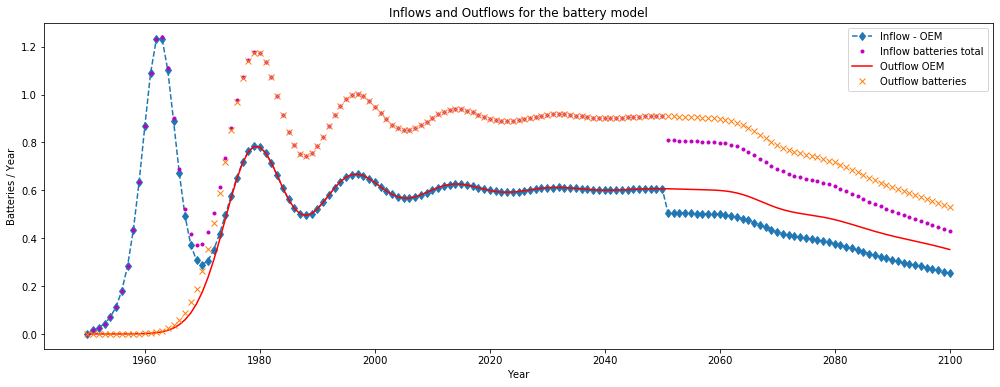

In [7]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_2, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_2, inflows_cars_2)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_2,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_2,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 3

Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can neither be replaced nor reused, meaning that if either the car or the battery fail, they are both scrapped.

In this case, the combined lifetimes of the battery and the car yield a smaller effective lifetime that dictates the outflows based on all failures. This would be a similar case as 1, but the effective lifetime choice is more explicit and potentially more robust, since it considers aspects of both products. 

Since now we have two pdf curves causing the outflows, the commulative probability of the pdf curve is greater than 1. Therefore, we need to aggregate the two lifetimes and create a combined one. 

A different battery lifetime is chosen here to better illustrate the case. 

In [8]:
stock_change_3 = [0] + np.diff(stock_cars).tolist()
outflows_cars_3 = [0]
outflows_batteries_3 = [0]
inflows_cars_3 = [0]
inflows_AM_battery_3 = [0]
stock_batteries_3 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 16
st_dev_car = 4

lifetime_battery = 10
st_dev_battery = 3

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

pdf_battery = np.zeros(years)
for age in range(years):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Creating effective lifetime
pdf_effective = np.zeros(years)
i = 0
while (sum(pdf_car[:i]) + sum(pdf_battery[:i]))<=1:
    pdf_effective[i] = pdf_car[i] + pdf_battery[i]
    i += 1
else:
    pdf_effective[i] = 0
pdf_effective = pdf_effective/sum(pdf_effective) # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_3 = 0
    new_outflow_battery_3 = 0
    for cohort in range(i):
        new_outflow_3 += inflows_cars_3[cohort] * pdf_effective[i-cohort]
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
        new_outflow_battery_3 = new_outflow_3
    outflows_cars_3.append(new_outflow_3)    
    inflows_cars_3.append(stock_change_3[i] + outflows_cars_3[i])
    outflows_batteries_3.append(new_outflow_battery_3) 
    # additional batteries needed for replacements
    inflows_AM_battery_3.append(new_outflow_battery_3 - new_outflow_3)
    stock_batteries_3.append(stock_batteries_3[-1] + inflows_cars_3[-1] - new_outflow_3)

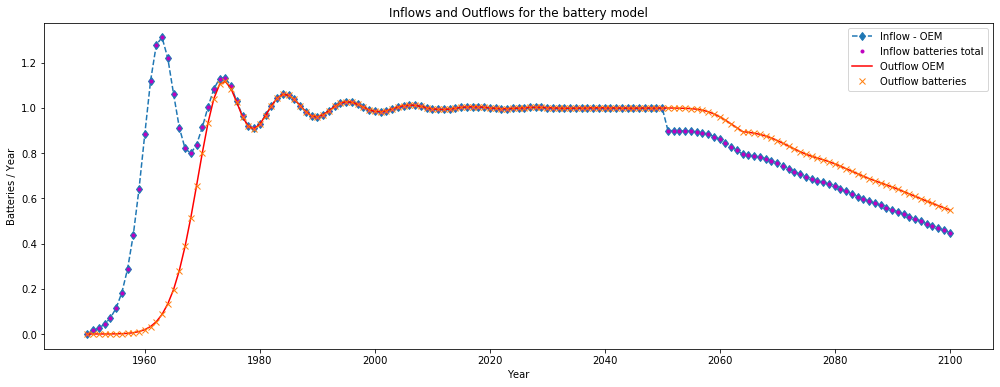

In [9]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_3, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_3, inflows_cars_3)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_3,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_3,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

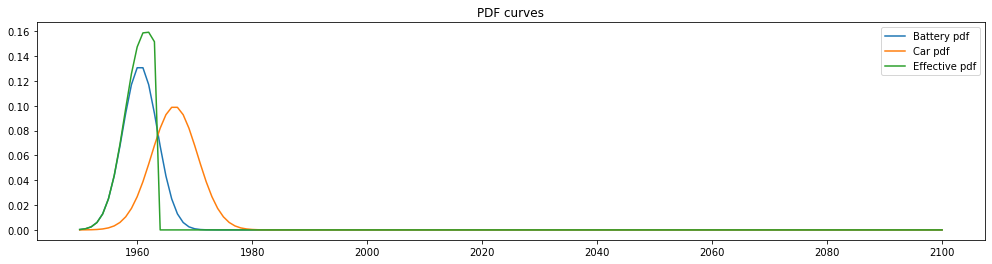

In [10]:
plt.figure(figsize=(17, 4))
plt.plot(time, pdf_battery, label='Battery pdf')
plt.plot(time, pdf_car, label='Car pdf')
plt.plot(time, pdf_effective, label='Effective pdf')
plt.title('PDF curves')
plt.legend(loc='best')

We end up with some sort of truncated normal distribution for the effective lifetime if the two products have a similar lt. If one of the products has a significantly smaller lifetime than the other, as was the case with the chosen lifetimes before, then that product will dictate the dynamics of both. 

We have here two interesting things: First, because of the vehilce outflows there is a large share of batteries that leave the fleet even if their condition would still be acceptable. Since replacements are not allowed, they would be perfect candidates for reuse in other applications. This would be the case if the cost of replacing your battery is prohibitively large. Second, there would be a large share of vehicles that leave the fleet due to battery failures early on as well. Again, not having battery replacements would lead to significant underuse of those vehicles. 

## Case 4 
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries cannot be replaced, but they can be reused. If the battery fails, the car is scrapped. If the car fails but the status of the battery is still good, it can be reused in a new car (we call this reuse rate R in the table). This case does not necessarily make sense for cars, but could be useful for other applications.

We can also take the effective lifetime approach and define the batteries that are still reusable as the area between the effective lifetime above the battery pdf, which is equal to the vehicle outflows with funcitoning batteries. The vehicle outflows still depend on the effective lifetime, but the battery outflows are mitigated by the reuse. An added logic may be needed for defining how many batteries from the total should be reused, as some of them could fail very quickly after the reuse has taken place. 

In [11]:
stock_change_4 = [0] + np.diff(stock_cars).tolist()
outflows_cars_4 = [0]
outflows_batteries_4 = [0]
inflows_cars_4 = [0]
inflows_AM_battery_4 = [0]
stock_batteries_4 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 16
st_dev_car = 4

lifetime_battery = 7
st_dev_battery = 3

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

pdf_battery = np.zeros(years)
for age in range(years):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Creating effective lifetime
pdf_effective = np.zeros(years)
i = 0
while (sum(pdf_car[:i]) + sum(pdf_battery[:i]))<=1:
    pdf_effective[i] = pdf_car[i] + pdf_battery[i]
    i += 1
else:
    pdf_effective[i] = 0
pdf_effective = pdf_effective/sum(pdf_effective) # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_4 = 0
    new_outflow_battery_4 = 0
    for cohort in range(i):
        new_outflow_4 += inflows_cars_4[cohort] * pdf_effective[i-cohort]
        if pdf_effective[i-cohort] > pdf_battery[i-cohort]:
            reuse += inflows_cars_4[cohort] * pdf_car[i-cohort]
        else:
            reuse = 0
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
        new_outflow_battery_4 += inflows_cars_4[cohort] * pdf_effective[i-cohort] -reuse
    outflows_cars_4.append(new_outflow_4)    
    inflows_cars_4.append(stock_change_4[i] + outflows_cars_4[i])
    outflows_batteries_4.append(new_outflow_battery_4) 
    # additional batteries needed for replacements
    inflows_AM_battery_4.append(new_outflow_battery_4 - new_outflow_4)
    stock_batteries_4.append(stock_batteries_4[-1] + inflows_cars_4[-1] - new_outflow_4)

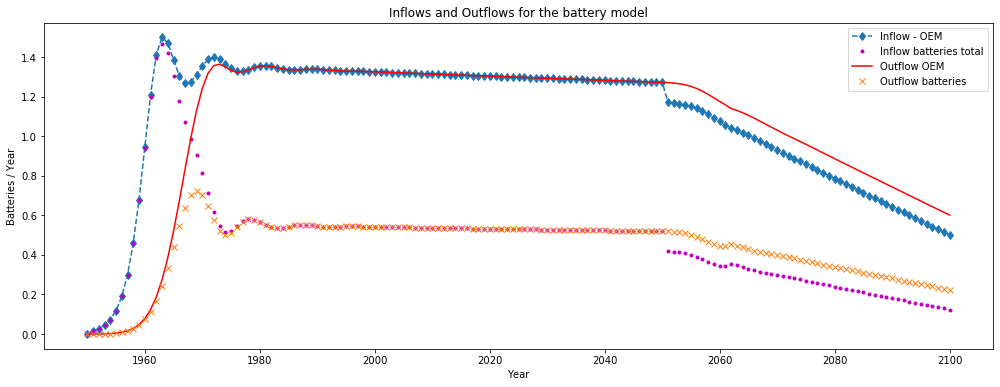

In [12]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_4, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_4, inflows_cars_4)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_4,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_4,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

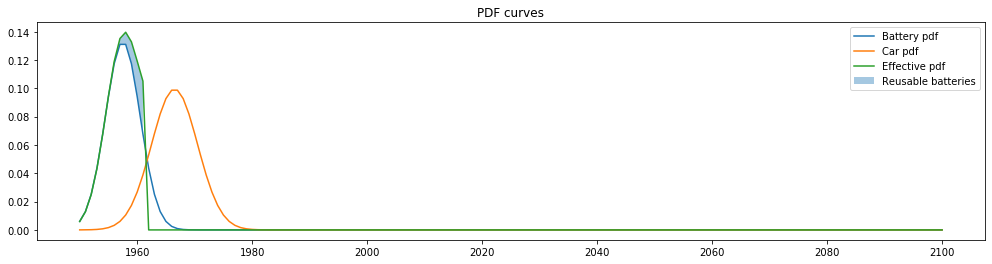

In [13]:
plt.figure(figsize=(17, 4))
plt.plot(time, pdf_battery, label='Battery pdf')
plt.plot(time, pdf_car, label='Car pdf')
plt.plot(time, pdf_effective, label='Effective pdf')
plt.fill_between(time[:pdf_effective.nonzero()[0][-1]+1], pdf_battery[:pdf_effective.nonzero()[0][-1]+1],pdf_effective[:pdf_effective.nonzero()[0][-1]+1],  alpha=0.4, label='Reusable batteries' )
plt.title('PDF curves')
plt.legend(loc='best')

Without an additional logic, if the lifetimes of the vehicles and batteries are similar, there are always enough batteries to reuse for new vehicles. One option would be to introduce a factor that estimates which share of batteries can be reused for this purpose. However, it might be more meaningful to do this based on the lifetime that the batteries have still remaining (survival curves, similar approach as the renovation in buildings).

## Case 5
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can be replaced, but they cannot be reused. If the car fails, the battery is scrapped. If the battery fails but the car is still in good shape, a new battery can be used to make the car operational again. Since the lifetimes of the car and the batteries are independent, replacing the battery should have no effect on the car’s lifetime. 

In this case the lifetime of the car is not limited by the lifetime of a battery. Without an additional logic, this means that battery replacements will always happen to allow the vehicle to live the full extent of it's expected lifetime. As a consequence, there can be batteries that are barely used in the fleet that are being scrapped wiht the vehicle. To avoid this, we could again rely on the survival function to only replace batteres that are either under warranty or that will stay in the fleet for a reasonable amount of time. 

In [14]:
stock_change_5 = [0] + np.diff(stock_cars).tolist()
outflows_cars_5 = [0]
outflows_batteries_5 = [0]
inflows_cars_5 = [0]
inflows_AM_battery_5 = [0]
stock_batteries_5 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 16
st_dev_car = 4

lifetime_battery = 7
st_dev_battery = 0.5

years = len(time)

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

pdf_battery = np.zeros(years)
for age in range(years):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_5 = 0
    new_outflow_battery_5 = 0
    for cohort in range(i):
        new_outflow_5 += inflows_cars_5[cohort] * pdf_car[i-cohort]
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries
        new_outflow_battery_5 += (inflows_cars_5[cohort] + inflows_AM_battery_5[cohort])  * pdf_battery[i-cohort]
        # The demand for battery replacements is given by the battery failures, the total need for batteries is:
        # If no additional logic is provided for the battery replacements, then we can assume that all batteries from vehicle failures can be reused for replacements

    outflows_cars_5.append(new_outflow_5)    
    inflows_cars_5.append(stock_change_5[i] + outflows_cars_5[i])
    outflows_batteries_5.append(new_outflow_battery_5) 
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_5.append(new_outflow_battery_5 - new_outflow_5)
    stock_batteries_5.append(stock_batteries_5[-1] + inflows_cars_5[-1] - new_outflow_5)

# Alternaive calculation using replacement rate
# The effective replacement rate is defined as the ratio between the inflows of AM batteries and OEM batteries
real_replacement_rate = [AM / OEM for (AM, OEM) in zip(inflows_AM_battery_5[1:], inflows_cars_5[1:]) ]
# inflows_AM_rate shows what would be the inflows of batteries if calculated from a constant replacement rate
inflows_AM_rate_5 = [np.mean(real_replacement_rate) * inflow for inflow in inflows_cars_5]

There are several interesting things that we can do with this case. We should have a case with an added logic for when a vehicle gets a replacement battery or not. We could also show the age of the outgoing batteries to make a case for reuse in other applications.

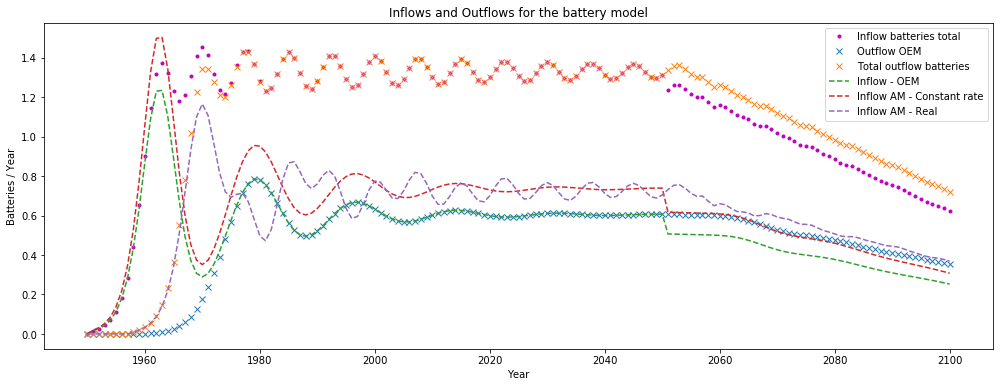

In [15]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_5, inflows_cars_5)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_5,'x', label='Outflow OEM')
plt.plot(time, outflows_batteries_5,'x', label='Total outflow batteries')
plt.plot(time, inflows_cars_5, '--', label='Inflow - OEM')
plt.plot(time, inflows_AM_rate_5,'--', label='Inflow AM - Constant rate')
plt.plot(time, inflows_AM_battery_5,'--', label='Inflow AM - Real')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

mean replacement rate: 1.2174095858104146


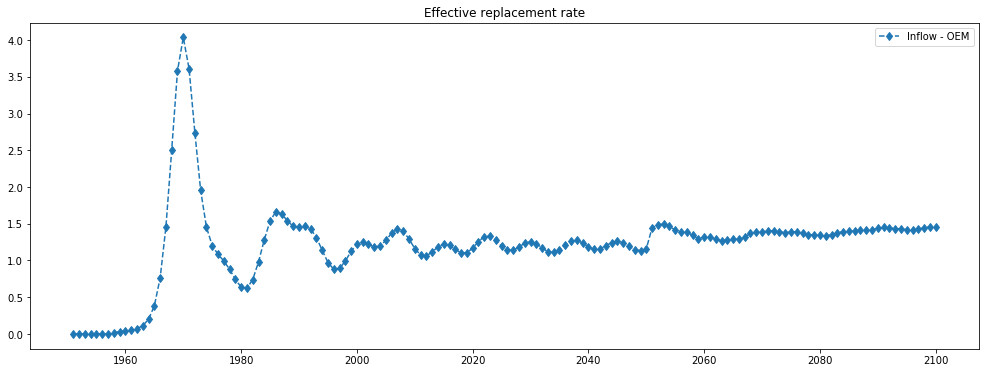

In [16]:
# Plot the effective replacement rate
plt.figure(figsize=(17, 6))
plt.plot(time[1:], real_replacement_rate, 'd--', label='Inflow - OEM')
plt.title('Effective replacement rate')
plt.legend(loc='best')
print("mean replacement rate:", np.mean(real_replacement_rate))


## Case 6
Cars and batteries have independent lifetimes. Potential failure of the battery is not included in the lifetime of the car. Batteries can be replaced and/or reused. If the car fails but the status of the battery is still good, the battery can be reused in another car. If the battery fails but the car is still in good shape, a new battery can be used to make the car operational again. Since the lifetimes of the car and the batteries are independent, replacing the battery should have no effect on the car’s lifetime. Similarly, a battery that is reused in another car keeps its age and lifetime. Such a model would probably use parameters and transfer coefficients to determine the share of cars and batteries that will be reused depending on their age.

Assuming that all batteries that flow out in the vehicles are reusable would lead to an overestimation of the amount of batteries that are actually fit to be reused. Instead, a logic is needed here to make a reasonable assumption. We reuse only the share of batteries that would be still be usable according to their own technical lifetime. This logic can be further developed to use only the share of batteries that will be still useful for a specified minimum amount of time tau. 

In [17]:
stock_change_6 = [0] + np.diff(stock_cars).tolist()
outflows_cars_6 = [0]
outflows_batteries_6 = [0]
inflows_cars_6 = [0]
inflows_AM_battery_6 = [0]
stock_batteries_6 = [0]

# Definition of lifetime vectors for cars 

lifetime_car = 16
st_dev_car = 4

lifetime_battery = 7
st_dev_battery = 1

years = len(time)

# defining minimum required amount of time criteria for reusability of batteries
tau_bat = 3

pdf_car = np.zeros(years)
for age in range(years):
    pdf_car[age] = norm(lifetime_car, st_dev_car).cdf(age) - norm(lifetime_car, st_dev_car).cdf(age - 1)
pdf_car = pdf_car/sum(pdf_car) # to ensure that the sum of the pdf function is 1 

pdf_battery = np.zeros(years+tau_bat)
for age in range(years+tau_bat):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

# defining survival curves
sf_battery = 1-np.cumsum(pdf_battery)
sf_car = 1-np.cumsum(pdf_car)



#Stock-driven model
for i in range(1,len(stock_cars)): # Added here -tau_bat to avoid errors in the code for exceeding the model's time
    new_outflow_6 = 0
    new_outflow_battery_6 = 0
    for cohort in range(i):
        new_outflow_6 += inflows_cars_6[cohort] * pdf_car[i-cohort]
        # the share of batteries that can be reused will be decided by specifying a minumum amount of time that those batteries need to be useful for after the replacement takes place, given their age. 
        reusable_batteries = sf_battery[i-cohort+tau_bat] # This includes only the batteries that came with the OEM. A separate calculation is needed for the new replacement batteries that are reused.
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries minus the batteries that can be reused
        new_outflow_battery_6 += (inflows_cars_6[cohort] + inflows_AM_battery_6[cohort])  * pdf_battery[i-cohort] *(1-reusable_batteries)
    outflows_cars_6.append(new_outflow_6)    
    inflows_cars_6.append(stock_change_6[i] + outflows_cars_6[i])
    outflows_batteries_6.append(new_outflow_battery_6) 
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_6.append(new_outflow_battery_6 - new_outflow_6)
    stock_batteries_6.append(stock_batteries_6[-1] + inflows_cars_6[-1] - new_outflow_6)

# Alternaive calculation using replacement rate
# The effective replacement rate is defined as the ratio between the inflows of AM batteries and OEM batteries
real_replacement_rate = [AM / OEM for (AM, OEM) in zip(inflows_AM_battery_6[1:], inflows_cars_6[1:]) ]
# inflows_AM_rate shows what would be the inflows of batteries if calculated from a constant replacement rate
inflows_AM_rate_6 = [np.mean(real_replacement_rate) * inflow for inflow in inflows_cars_6]

 Also, since older batteries are used, we somehow need to keep track of the cohorts of the batteries separately from the cohorts of the vehicles, as they are no longer the same. 

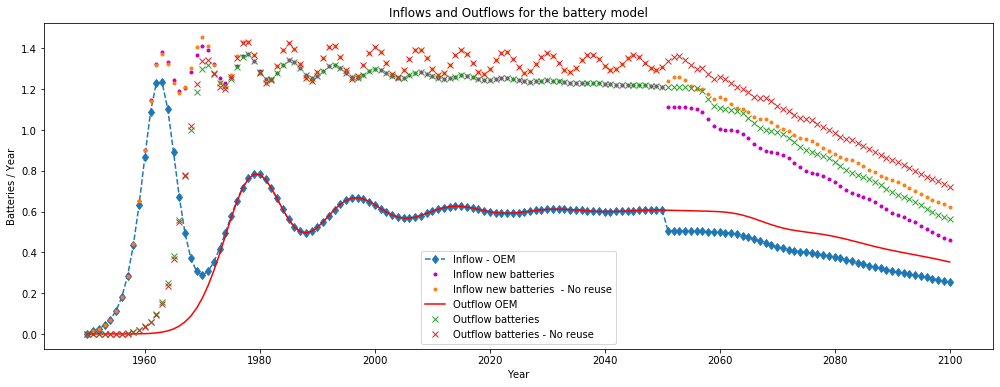

In [18]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_6, 'd--', label='Inflow - OEM')

plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_6, inflows_cars_6)], 'm.', label='Inflow new batteries ')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_5, inflows_cars_5)], '.', label='Inflow new batteries  - No reuse')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_6,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_6,'x', label='Outflow batteries')
plt.plot(time, outflows_batteries_5,'x', label='Outflow batteries - No reuse')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

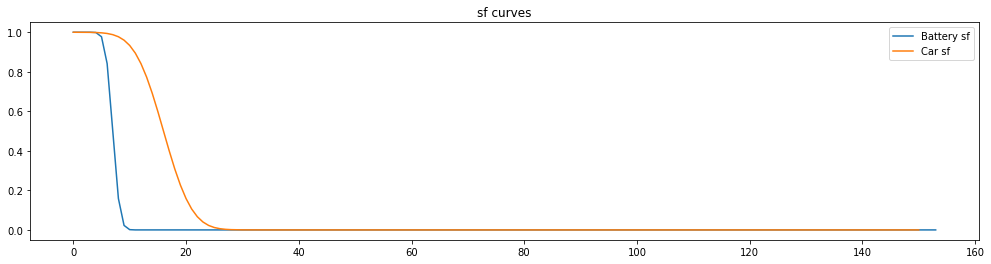

In [19]:
plt.figure(figsize=(17, 4))
plt.plot(range(len(sf_battery)), sf_battery, label='Battery sf')
plt.plot(range(len(sf_car)), sf_car, label='Car sf')
plt.title('sf curves')
plt.legend(loc='best')

Another thing that can be done is only replacing the battery of those vehicles which will still be in the fleet for a minimum required amount of time. This will avoid that we get new batteries for vehicles that are not 

## Case 7
The model does not use lifetimes at all. It would make sense if the inflows of cars and batteries are calculated as a percentage of the stock (Stock and birth rate model in the paper with Dirk). OK for models where the stock is stable, not suited for studying the penetration of new products and technologies. 1 car = 1 battery, no replacement allowed

This type of models can be driven by either a death or a birth rate. The battery outflows and the vehicle outflows are equivalent and the rate encompases failures in both products. 

In [20]:
stock_change_7a = [0] + np.diff(stock_cars).tolist()
outflows_cars_7a = [0]
outflows_batteries_7a = [0]
inflows_cars_7a = [0]
inflows_AM_battery_7a = [0]
stock_batteries_7a = [0]

# Death rate
d = 0.2

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_7a = 0
    new_outflow_battery_7a = 0
    for cohort in range(i):
        new_outflow_7a = stock_cars[cohort] * d
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries
        new_outflow_battery_7a = new_outflow_7a
        
    outflows_cars_7a.append(new_outflow_7a)    
    inflows_cars_7a.append(stock_change_7a[i] + outflows_cars_7a[i])
    outflows_batteries_7a.append(new_outflow_battery_7a) 
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_7a.append(new_outflow_battery_7a - new_outflow_7a)
    stock_batteries_7a.append(stock_batteries_7a[-1] + inflows_cars_7a[-1] - new_outflow_7a)


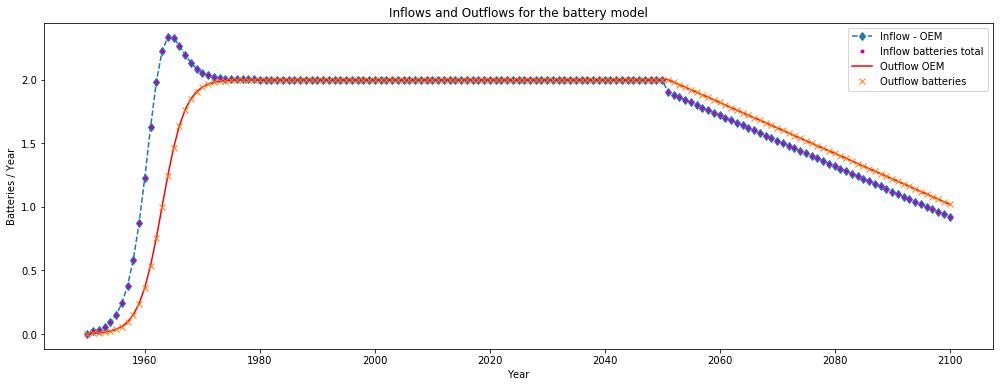

In [21]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_7a, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_7a, inflows_cars_7a)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_7a,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_7a,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

In [22]:
# Alternaive calculation using birth rate
stock_change_7b = [0] + np.diff(stock_cars).tolist()
outflows_cars_7b = [0]
outflows_batteries_7b = [0]
inflows_cars_7b = [0]
inflows_AM_battery_7b = [0]
stock_batteries_7b = [0]

# Birth rate
b = 0.6

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_7b = 0
    new_outflow_battery_7b = 0
    for cohort in range(i):
        new_inflow_7b = stock_cars[cohort] * b

    outflows_cars_7b.append(new_inflow_7b-stock_change_7b[i])    
    inflows_cars_7b.append(new_inflow_7b)
    outflows_batteries_7b = outflows_cars_7b
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_7b.append(outflows_batteries_7b[i] - outflows_cars_7b[i])
    stock_batteries_7b.append(stock_batteries_7b[-1] + inflows_cars_7b[-1] - new_outflow_7b)


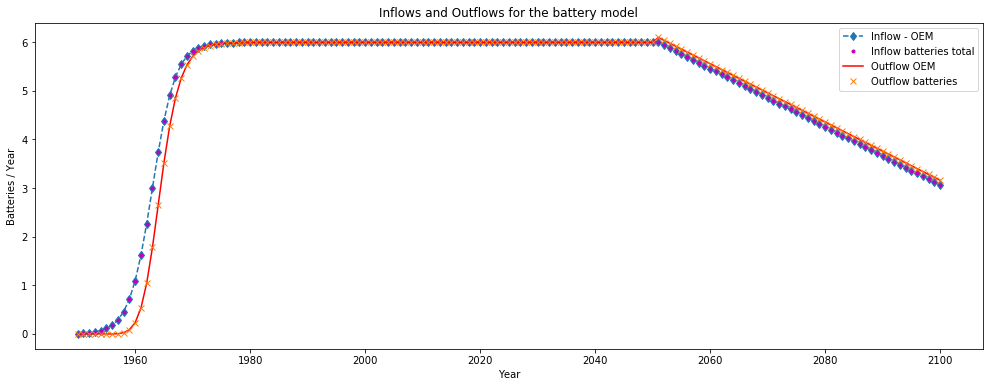

In [23]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_7b, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_7b, inflows_cars_7b)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_7b,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_7b,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 8	
The model does not use lifetimes at all. It would make sense if the inflows of cars and batteries are calculated as a percentage of the stock (Stock and birth rate model in the paper with Dirk). OK for models where the stock is stable, not suited for studying the penetration of new products and technologies.

In [24]:
stock_change_8a = [0] + np.diff(stock_cars).tolist()
outflows_cars_8a = [0]
outflows_batteries_8a = [0]
inflows_cars_8a = [0]
inflows_AM_battery_8a = [0]
stock_batteries_8a = [0]

# Death rate
d = 0.2

# Battery replacement rate
r = 2

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_8a = 0
    new_outflow_battery_8a = 0
    for cohort in range(i):
        new_outflow_8a = stock_cars[cohort] * d
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries
        new_outflow_battery_8a = new_outflow_8a * r
        
    outflows_cars_8a.append(new_outflow_8a)    
    inflows_cars_8a.append(stock_change_8a[i] + outflows_cars_8a[i])
    outflows_batteries_8a.append(new_outflow_battery_8a) 
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_8a.append(new_outflow_battery_8a - new_outflow_8a)
    stock_batteries_8a.append(stock_batteries_8a[-1] + inflows_cars_8a[-1] - new_outflow_8a)


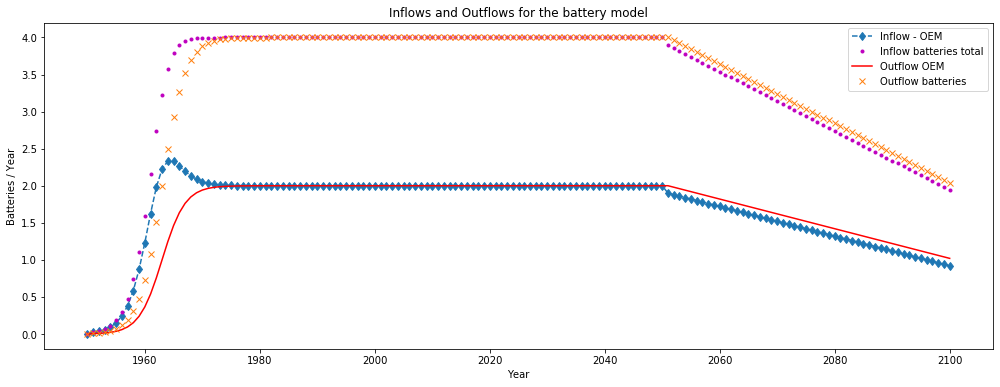

In [25]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_8a, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_8a, inflows_cars_8a)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_8a,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_8a,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

In [26]:
# Alternaive calculation using birth rate
stock_change_8b = [0] + np.diff(stock_cars).tolist()
outflows_cars_8b = [0]
outflows_batteries_8b = [0]
inflows_cars_8b = [0]
inflows_AM_battery_8b = [0]
stock_batteries_8b = [0]

# Birth rate
b = 0.6
# Battery replacement rate
r = 2

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_8b = 0
    new_outflow_battery_8b = 0
    for cohort in range(i):
        new_inflow_8b = stock_cars[cohort] * b
        new_inflow_battery_8b = new_inflow_8b * r

    outflows_cars_8b.append(new_inflow_8b-stock_change_8b[i])    
    inflows_cars_8b.append(new_inflow_8b)
    outflows_batteries_8b.append(new_inflow_battery_8b-stock_change_8b[i])
    # the batteries that were in scrapped cars are not replaced  
    inflows_AM_battery_8b.append(outflows_batteries_8b[i] - outflows_cars_8b[i])
    stock_batteries_8b.append(stock_batteries_8b[-1] + inflows_cars_8b[-1] - new_outflow_8b)

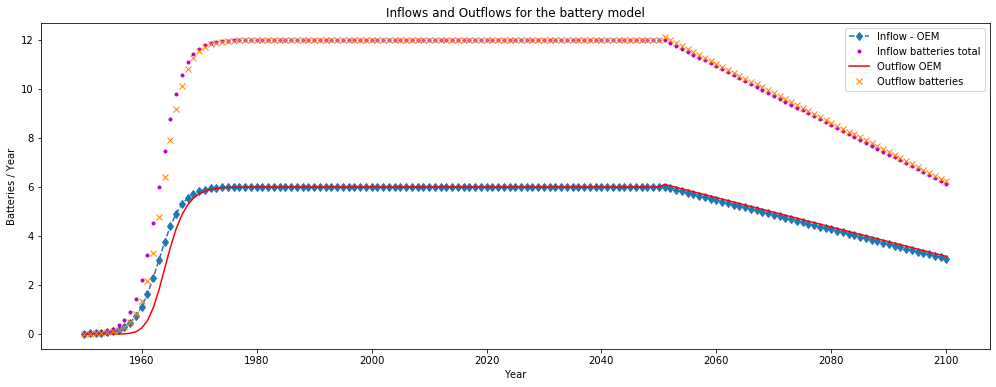

In [27]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_8b, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_8b, inflows_cars_8b)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_8b,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_8b,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 9
The lifetime of the car is mostly determined by the lifetime of the battery. No battery replacement, when it dies, the car dies.  There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. 1 car = one battery, Outflow battery = outflow car.  

Since the vehicle lifetime is defined by the battery lifetime and there is no replacement, we can model moth producs as in case 1 with the battery lifetime instead of the vehicle lifetime. 

In [28]:
stock_change_9 = [0] + np.diff(stock_cars).tolist()
outflows_cars_9 = [0]
outflows_batteries_9 = [0]
inflows_cars_9 = [0]
inflows_AM_battery_9 = [0]
stock_batteries_9 = [0]

# Definition of lifetime vectors for batteries 

lifetime_battery = 8
st_dev_battery = 2

years = len(time)

pdf_battery = np.zeros(years)
for age in range(years):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_9 = 0
    new_outflow_battery_9 = 0
    for cohort in range(i):
        new_outflow_9 += inflows_cars_9[cohort] * pdf_battery[i-cohort]
        new_outflow_battery_9 = new_outflow_9
        # the outflow of batteries from a cohort is equal to the outflows of the vehicles
    outflows_cars_9.append(new_outflow_9)    
    inflows_cars_9.append(stock_change_9[i] + outflows_cars_9[i])
    outflows_batteries_9.append(new_outflow_battery_9) 
    # additional batteries needed for replacements
    inflows_AM_battery_9.append(new_outflow_battery_9 - new_outflow_9)
    stock_batteries_9.append(stock_batteries_9[-1] + inflows_cars_9[-1] - new_outflow_9)

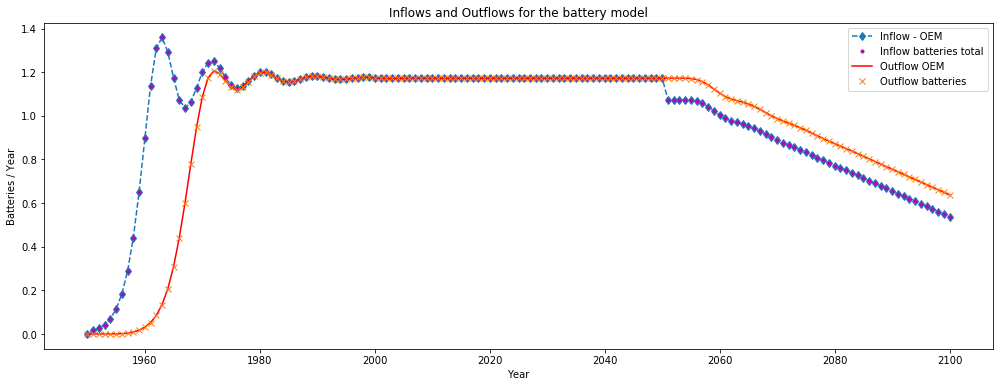

In [29]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_9, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_9, inflows_cars_9)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_9,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_9,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 10 
The lifetime of the car is mostly determined by the lifetime of the battery. No battery replacement, when it dies, the car dies, but some batteries from crashed cars can be reused in new cars.  There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery <= outflow car. This case is probably not the most meaningful.

In this case some of the batteries are deemed to be reusable. This makes sense if we consider that some of the outflows are due to vehicle failures. We can here consider then that only a fraction of the batteries that would qualify can actually be reused. Therefore, we define the survival curve of the battery and consider that only the share of batteries that would still be there after a certain amount of years theoretically qualifies for reuse, but because some of those batteries are in fact faulty, a factor is needed in addition. 

In [30]:
stock_change_10 = [0] + np.diff(stock_cars).tolist()
outflows_cars_10 = [0]
outflows_batteries_10 = [0]
inflows_cars_10 = [0]
inflows_AM_battery_10 = [0]
stock_batteries_10 = [0]

# Definition of lifetime vectors for batteries 

lifetime_battery = 12
st_dev_battery = 4

years = len(time)

tau_bat = 3
pdf_battery = np.zeros(years+tau_bat)
for age in range(years+tau_bat):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

# defining survival curve
sf_battery = 1-np.cumsum(pdf_battery)

# defining additional factor of useful batteries
r = 0.2

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_10 = 0
    new_outflow_battery_10 = 0
    for cohort in range(i):
        new_outflow_10 += inflows_cars_10[cohort] * pdf_battery[i-cohort]
        # reusable batteries
        reusable_batteries = sf_battery[i-cohort+tau_bat] * r # This includes only the batteries that came with the OEM. A separate calculation is needed for the new replacement batteries that are reused.
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries minus the batteries that can be reused
        new_outflow_battery_10 += (inflows_cars_10[cohort] + inflows_AM_battery_10[cohort])  * pdf_battery[i-cohort] *(1-reusable_batteries)
        #new_outflow_battery_10 = new_outflow_10 - reuse
    outflows_cars_10.append(new_outflow_10)    
    inflows_cars_10.append(stock_change_10[i] + outflows_cars_10[i])
    outflows_batteries_10.append(new_outflow_battery_10) 
    # New battery inflows
    inflows_AM_battery_10.append(new_outflow_battery_10 - new_outflow_10)
    stock_batteries_10.append(stock_batteries_10[-1] + inflows_cars_10[-1] - new_outflow_10)

    # Alternaive calculation using replacement rate
# The effective replacement rate is defined as the ratio between the inflows of AM batteries and OEM batteries
real_replacement_rate = [AM / OEM for (AM, OEM) in zip(inflows_AM_battery_10[1:], inflows_cars_10[1:]) ]
# inflows_AM_rate shows what would be the inflows of batteries if calculated from a constant replacement rate
inflows_AM_rate_10 = [np.mean(real_replacement_rate) * inflow for inflow in inflows_cars_10]
inflows_AM_rate_10 = [new_cars + reused_bats for new_cars , reused_bats in zip(inflows_cars_10, inflows_AM_rate_10)] 


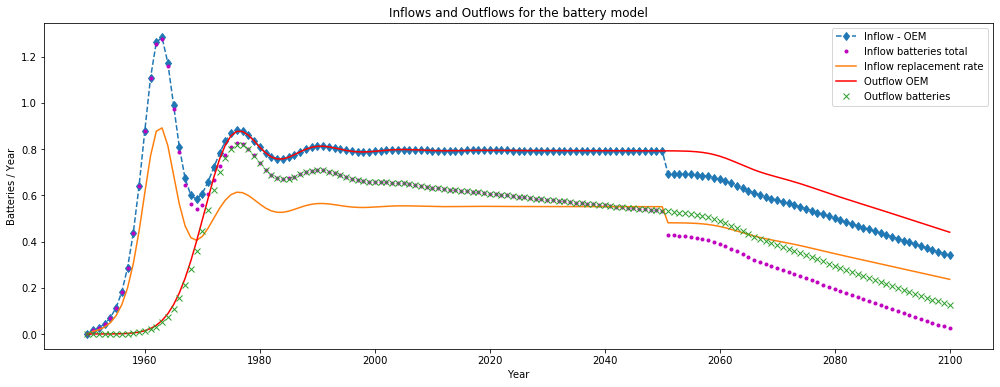

In [31]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_10, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_10, inflows_cars_10)], 'm.', label='Inflow batteries total')
plt.plot(time, inflows_AM_rate_10, label='Inflow replacement rate')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_10,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_10,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 11
The lifetime of the car is mostly determined by the lifetime of the battery. The battery can be replaced, but old batteries cannot be reused. This model assumes that a car would live infinitely as long as the battery keeps being replaced.There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery >= outflow car. 

In [80]:
stock_change_11 = [0] + np.diff(stock_cars).tolist()
outflows_cars_11 = [0]
outflows_batteries_11 = [0]
inflows_cars_11 = [0]
inflows_AM_battery_11 = [0]
stock_batteries_11 = [0]

# Definition of lifetime vectors for batteries 

lifetime_battery = 8
st_dev_battery = 2

# Death rate vehicles to account for accidents
r = 0.05

years = len(time)

pdf_battery = np.zeros(years)
for age in range(years):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_11 = 0
    new_outflow_battery_11 = 0
    for cohort in range(i):
        new_outflow_battery_11 += inflows_AM_battery_11[cohort] * pdf_battery[i-cohort]
        new_outflow_11 = stock_cars[cohort] * r
        # The outflow of batteries is determined by the battery lifetime but the outflow of vehicle is only determined by death rate to account for accidents, since they can get a battery replacement whenever it is needed.
    outflows_cars_11.append(new_outflow_11)    
    inflows_cars_11.append(stock_change_11[i] + outflows_cars_11[i])
    outflows_batteries_11.append(new_outflow_battery_11) 
    # additional batteries needed for replacements
    inflows_AM_battery_11.append(stock_change_11[i] + outflows_batteries_11[i])
    stock_batteries_11.append(stock_batteries_11[-1] + inflows_cars_11[-1] - new_outflow_11)

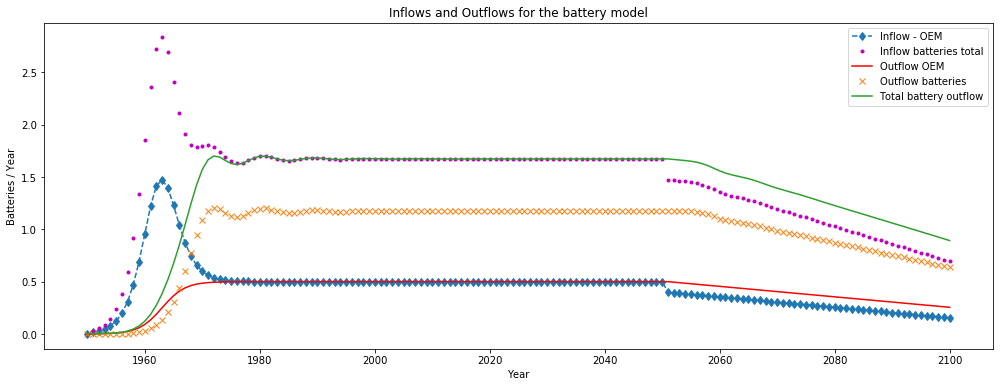

In [83]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_11, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_11, inflows_cars_11)], 'm.', label='Inflow batteries total')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_11,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_11,'x', label='Outflow batteries')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(outflows_batteries_11, outflows_cars_11)], label='Total battery outflow')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 12
The lifetime of the car is mostly determined by the lifetime of the battery. The battery can be replaced, and old batteries can be reused. This model assumes that a car would live infinitely as long as the battery keeps being replaced. There should be some extra outflows of cars as well (accidents), which could be modelled by a stock and death rate approach. Outflow battery <= or >= outflow car depending on assumptions for reuse and replacement.

We take a similar approach to case 6 here, only the cars do not have a lifetime and therefore are always elegible to get a battery replacement. The rules for when a battery can be reused become more tricky because we now assume that pretty much all outflows are because of battery failured. So what we do is take the share of batteries that is exiting the fleet due to vehicle crashes and take a share of them for reuse. Since there is a leaching approach, we do not know the cohort of the vehicles being crashed and therefore we have to assume that the batteroes will be fit for reuse for a full battery lifetime. 

In [102]:
stock_change_12 = [0] + np.diff(stock_cars).tolist()
outflows_cars_12 = [0]
outflows_batteries_12 = [0]
inflows_cars_12 = [0]
inflows_AM_battery_12 = [0]
stock_batteries_12 = [0]

# Definition of lifetime vectors for batteries 

lifetime_battery = 8
st_dev_battery = 2

# Death rate vehicles to account for accidents
r = 0.05

# defining additional factor of useful batteries
R = 0.2

years = len(time)

tau_bat = 3
pdf_battery = np.zeros(years+tau_bat)
for age in range(years+tau_bat):
    pdf_battery[age] = norm(lifetime_battery, st_dev_battery).cdf(age) - norm(lifetime_battery, st_dev_battery).cdf(age - 1)
pdf_battery = pdf_battery/sum(pdf_battery)  # to ensure that the sum of the pdf function is 1

#Stock-driven model
for i in range(1,len(stock_cars)):
    new_outflow_12 = 0
    new_outflow_battery_12 = 0
    for cohort in range(i):
        new_outflow_12 = stock_cars[cohort] * r
        # The outflow of batteries is determined by the battery lifetime but the outflow of vehicle is only determined by death rate to account for accidents, since they can get a battery replacement whenever it is needed. A share of the batteries in crashed vehicles can still be considered useful for reuse
        reusable_batteries = sf_battery[i-cohort+tau_bat] * r # This includes only the batteries that came with the OEM. A separate calculation is needed for the new replacement batteries that are reused.
        # the outflow of batteries from a cohort is the sum of OEM batteries (inflows_cars) and AM batteries minus the batteries that can be reused
        new_outflow_battery_12 += (inflows_cars_12[cohort] + inflows_AM_battery_12[cohort])  * pdf_battery[i-cohort] *(1-reusable_batteries)

    outflows_cars_12.append(new_outflow_12)    
    inflows_cars_12.append(stock_change_12[i] + outflows_cars_12[i])
    outflows_batteries_12.append(new_outflow_battery_12) 
    # additional batteries needed for replacements
    inflows_AM_battery_12.append(new_outflow_battery_12 - new_outflow_12)
    stock_batteries_12.append(stock_batteries_12[-1] + inflows_cars_12[-1] - new_outflow_12)

    # Alternaive calculation using replacement rate
# The effective replacement rate is defined as the ratio between the inflows of AM batteries and OEM batteries
real_replacement_rate = [AM / OEM for (AM, OEM) in zip(inflows_AM_battery_12[1:], inflows_cars_12[1:]) ]
# inflows_AM_rate shows what would be the inflows of batteries if calculated from a constant replacement rate
inflows_AM_rate_12 = [np.mean(real_replacement_rate) * inflow for inflow in inflows_cars_12]
inflows_AM_rate_12 = [new_cars + reused_bats for new_cars , reused_bats in zip(inflows_cars_12, inflows_AM_rate_12)] 

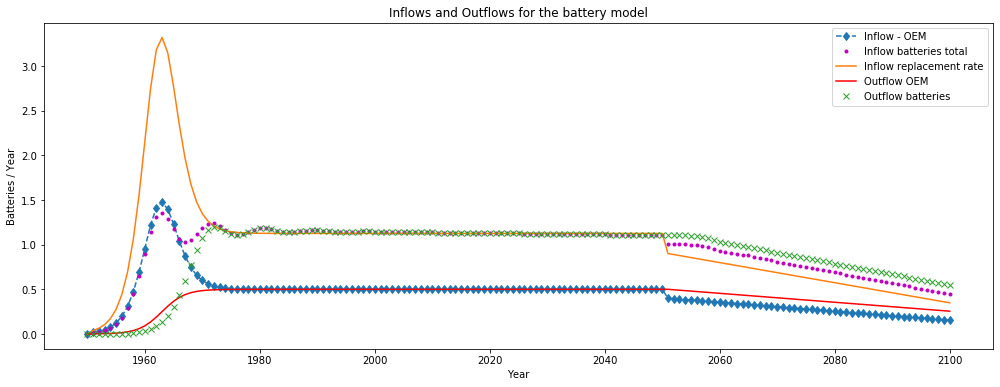

In [103]:
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, inflows_cars_12, 'd--', label='Inflow - OEM')
plt.plot(time, [AM + OEM for (AM, OEM) in zip(inflows_AM_battery_12, inflows_cars_12)], 'm.', label='Inflow batteries total')
plt.plot(time, inflows_AM_rate_12, label='Inflow replacement rate')
# inflows_AM_rate Shows what would be the inflows of batteries if calculated from a constant replacement rate
plt.plot(time, outflows_cars_12,'r', label='Outflow OEM')
plt.plot(time, outflows_batteries_12,'x', label='Outflow batteries')
plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')